In [1]:
###-----------------
### Import Libraries
###-----------------

import os

import pandas as pd

import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay


import tensorflow as tf

    
%matplotlib inline

In [2]:
###------------------
### Memory Management
###------------------

physical_devices = tf.config.list_physical_devices('GPU') 

if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [24]:
###---------------------------------------
### Global  parameters and Hyperparamaters
###---------------------------------------

inpDir = '/home/dai/directory_env/input' # location where input data is stored
outDir = '/home/dai/directory_env/output' # location to store outputs
subDir = 'flower_photos' # location of the images
modelDir = '/home/dai/directory_env/models' # location to save model files
valDir = 'valid_flowers' # location related to this dataset
altName = 'dropout_bn_no_bias_leaky_flowers' # Model file name for this alternative

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
tf.random.set_seed(RANDOM_STATE)


EPOCHS = 100   # number of cycles to run

ALPHA = 0.01

BATCH_SIZE = 16

TEST_SIZE = 0.2

IMG_HEIGHT = 224

IMG_WIDTH = 224

FLIP_MODE = "horizontal_and_vertical"

# for rotation transformation 
ROTATION_FACTOR = (-0.1, 0.1) 

FILL_MODE = 'nearest'

ES_PATIENCE = 20 # if performance does not improve stop

LR_PATIENCE = 10 # if performace is not improving reduce alpha

LR_FACTOR = 0.5 # rate of reduction of alpha

RATE = 0.2


# Set parameters for decoration of plots
params = {'legend.fontsize' : 'large',
          'figure.figsize'  : (15,6),
          'axes.labelsize'  : 'x-large',
          'axes.titlesize'  :'x-large',
          'xtick.labelsize' :'large',
          'ytick.labelsize' :'large',
         }

CMAP = plt.cm.brg

plt.rcParams.update(params) # update rcParams

### Helper Function

In [4]:

def fn_plot_hist(hist_df):
    
    '''
    Args:
        hist_df: a dataframe with following ccolumns
            column 0: loss
            column 1: accuracy
            column 2: val_loss
            column 3: val_accuracy
            While plotting columns are accessed by index 
            so that even if the column names are different it will not throw exceptions.
    '''
        
    # create figure and axis array
    fig, axes = plt.subplots(1,2 , figsize = (15,6))

    # properties  matplotlib.patch.Patch 
    props = dict(boxstyle='round', facecolor='aqua', alpha=0.4)

    # take first axis
    ax = axes[0]

    # Plot Column 0 and 2 (Loss and validation loss)
    hist_df.plot(y = [hist_df.columns[0],hist_df.columns[2]], ax = ax, colormap=CMAP)

    # get minimum values for plotting
    lossmin = hist_df[hist_df.columns[0]].min()

    testmin = hist_df[hist_df.columns[2]].min()

    # little beautification
    txtstr = "Min {}: \n Training : {:7.4f}\n Testing   : {:7.4f}".format(hist_df.columns[0],
                                                                          lossmin,
                                                                          testmin) #text to plot

    # place a text box in upper left in axes coords
    ax.text(0.4, 0.95, txtstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)

    # label the axes
    ax.set_xlabel("Epochs")

    ax.set_ylabel(hist_df.columns[0].capitalize())

    # grids make it look good
    ax.grid()
    
    # take second axis object
    ax = axes[1]

    # plot column 1 and 3 (accuracy and validation accuracy)
    hist_df.plot( y = [hist_df.columns[1], hist_df.columns[3]], ax = ax, colormap=CMAP)

    # little beautification
    accmin = hist_df[hist_df.columns[1]].max()
    testmin = hist_df[hist_df.columns[3]].max()
    txtstr = "Max {}: \n Training : {:7.4f}\n Testing   : {:7.4f}".format(hist_df.columns[1],
                                                                                accmin,
                                                                                testmin) #text to plot

    # place a text box in upper left in axes coords
    ax.text(0.4, 0.5, txtstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)

    # label the axes
    ax.set_xlabel("Epochs")
    
    ax.set_ylabel(hist_df.columns[1].capitalize())
    
    # grids make it look good
    ax.grid()
    
    # fit the subplot(s) in to the figure area
    plt.tight_layout()
    
    # display all open images
    plt.show()

In [5]:
# Function to plot number of classes in training and testing sets
def fn_plot_label(tr_ds, ts_ds):
    
    '''
        Args:
            tr_ds :  Training Dataset
            ts_ds : Testing dataset
        Returns : none
    '''

    # create figure
    plt.figure(figsize = (15,5))
    
    # create two subplots
    plt.subplot(1,2,1)

    # create array of training labels
    train_labels = tf.concat([y for x, y in tr_ds], axis = 0).numpy()
    
    # get unique labels and counts thereof
    unique, _, counts = tf.unique_with_counts(train_labels)
    
    # bar plot
    plt.bar(range(len(unique)), counts, align='center',color = 'DarkBlue', alpha = 0.7)
    
    # add title
    plt.title('Training Set')
    
    # add ticks on axis
    plt.xticks(range(len(unique)), class_names)
    
    # grids make it look good
    plt.grid()


    #pick second image
    plt.subplot(1,2,2)

    # create array of testing labels 
    val_labels = tf.concat([y for x, y in ts_ds], axis = 0).numpy()
    
    # get unique labels and counts thereof
    unique, _, counts = tf.unique_with_counts(val_labels)
    
    # bar plot
    plt.bar(range(len(unique)), counts, align='center', color = 'Orange', alpha = 0.7)
    
    # add title
    plt.title('Test Set')
    
    # add ticks
    plt.xticks(range(len(unique)), class_names)
    
    # grids make it look good
    plt.grid()
    
    # fit the subplot(s) in to the figure area
    plt.tight_layout()
    
    # display all open figures
    plt.show()

## Load Dataset

Images are under flower_photos

     |- daisy
     |- dandelion
     |- roses
     |- sunflowers
     |- tulips

In [6]:
'''
    For reading from web link
'''

import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url,
                                  fname='flower_photos',
                                  untar=True)
#data_dir = pathlib.Path(data_dir)
# '''
#     For reading from local directory
# '''
# data_dir = os.path.join(inpDir, subDir)

228813984/228813984 [==============================] - 1s 0us/step


In [7]:
data_dir

'/root/.keras/datasets/flower_photos'

In [8]:
#list content of data_dir
os.listdir(data_dir)

['sunflowers', 'dandelion', 'LICENSE.txt', 'roses', 'daisy', 'tulips']

In [9]:
data_dir= '/root/.keras/datasets/flower_photos'

### Train and Test Datasets

In [10]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=TEST_SIZE,
    subset='training',
    seed= RANDOM_STATE,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=TEST_SIZE,
    subset='validation',
    seed= RANDOM_STATE,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE)


Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


### Is it picking the class names?

In [11]:
class_names = train_ds.class_names
print('total ', len(class_names), class_names)

total  5 ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


In [12]:
train_ds.take(1)

<TakeDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

### Verify the data
To verify that the dataset looks correct, let's plot the first batch from the training set and display the class name below each image.

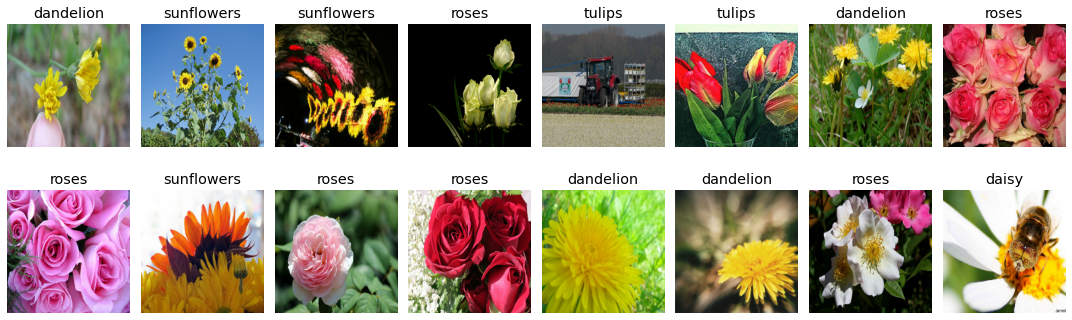

In [13]:
# set figure size
plt.figure(figsize=(15,5))

# take one batch of the dataset
for images, labels in train_ds.take(1):
    
    # iterate through the batch
    for i in range(BATCH_SIZE):
        
        # add a subplot
        plt.subplot(int(BATCH_SIZE/8), 8, i+1 )
        
        # switch off the grids
        plt.grid(False)
        
        # image_size may have converted these images to float
        plt.imshow(images[i].numpy().astype("uint8")) 
        
        # display class in the title
        plt.title(class_names[labels[i]])
        
        # no axis
        plt.axis("off")
        
    # fit the subplot(s) in to the figure area
    plt.tight_layout()
    
# display all open images    
plt.show()

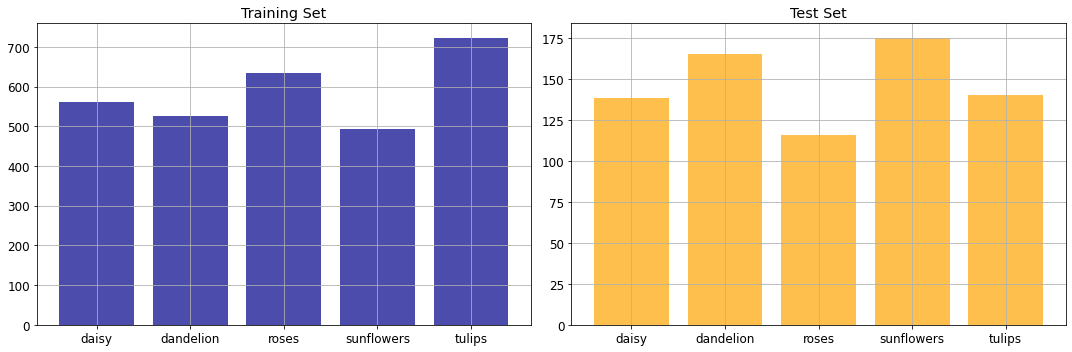

In [14]:
# how many examples in each of the class
fn_plot_label(train_ds, test_ds)

In [15]:
# pick the input_shape 

input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)

## RandomZoom

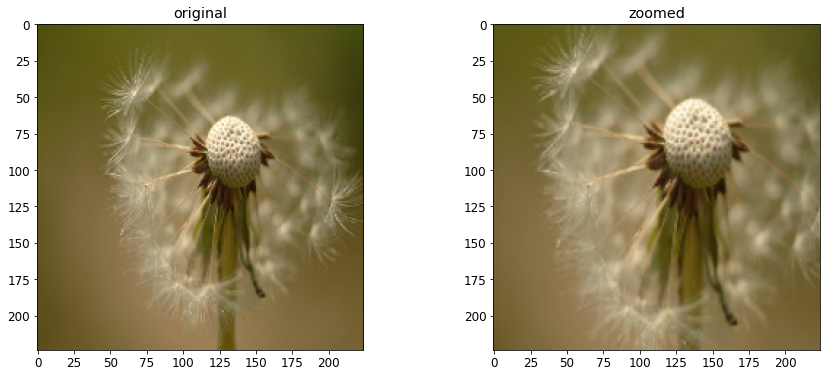

In [16]:
layer = tf.keras.layers.RandomZoom(height_factor=(-0.2,-0.2),
                                   width_factor=(-0.2,-0.2)
                                  )

plt.figure()

img_num = 3

for images, labels in train_ds.take(1):
    
    out_images = layer(images)
    
    plt.subplot(1,2,1)
    
    plt.title('original')
    
    plt.imshow(images[img_num].numpy().astype('uint8'))
    
    plt.subplot(1,2,2)
    
    plt.title('zoomed')
    
    plt.imshow(out_images[img_num].numpy().astype('uint8'))
 

## Random Rotation

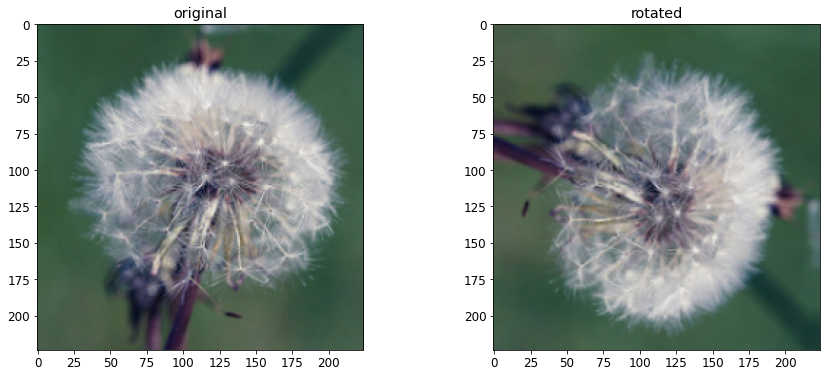

In [17]:
layer = tf.keras.layers.RandomRotation((-0.5, 0.5),
                                       fill_mode='nearest')

plt.figure()

img_num = 3

for images, labels in train_ds.take(1):
    
    out_images = layer(images)
    
    plt.subplot(1,2,1)
    
    plt.title('original')
    
    plt.imshow(images[img_num].numpy().astype('uint8'))
    
    plt.subplot(1,2,2)
    
    plt.title('rotated')
    
    plt.imshow(out_images[img_num].numpy().astype('uint8'))

### Standardize the data
The original RGB channel values are in the [0, 255] range. Resizing has converted those values into floats. Standardize values to be in the [0, 1] range by using the tf.keras.layers.experimental.preprocessing.Rescaling layer.

In [18]:
## Optimize for performance
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

## VGG 16 Model

![image.png](attachment:image.png)

In [19]:
import tensorflow as tf

model = tf.keras.Sequential([
    # Block 1
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(2, 2),
    
    tf.keras.layers.Dropout(RATE),
    
    # Block 2
    tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(2, 2),
    tf.keras.layers.Dropout(RATE),

    # Block 3
    tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(2, 2),
    tf.keras.layers.Dropout(RATE),

    # Block 4
    tf.keras.layers.Conv2D(512, 3, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(512, 3, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(512, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(2, 2),
    tf.keras.layers.Dropout(RATE),
    
    # Block 5
    tf.keras.layers.Conv2D(512, 3, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(512, 3, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(512, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(2, 2),
    tf.keras.layers.Dropout(RATE),
    
    # Classification block
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(RATE),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(RATE),
    tf.keras.layers.Dense(5) #activation='softmax'),

    
])


In [20]:
early_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  restore_best_weights=True,
                                                  patience=ES_PATIENCE,
                                                  verbose=1)

In [21]:
model.compile(optimizer=tf.keras.optimizers.SGD(),
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 112, 112, 64)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 128)     147584    
                                                        

In [25]:
history = model.fit(train_ds,
                    validation_data=test_ds,
                   epochs=EPOCHS,
                   batch_size=AUTOTUNE,
                   callbacks= [early_callback] )

Epoch 1/100
184/184 [==============================] - 51s 278ms/step - loss: 0.9949 - accuracy: 0.6144 - val_loss: 1.3683 - val_accuracy: 0.4401
Epoch 2/100
184/184 [==============================] - 51s 275ms/step - loss: 0.9515 - accuracy: 0.6274 - val_loss: 1.1696 - val_accuracy: 0.5422
Epoch 3/100
184/184 [==============================] - 50s 270ms/step - loss: 0.9198 - accuracy: 0.6420 - val_loss: 1.3142 - val_accuracy: 0.4632
Epoch 4/100
184/184 [==============================] - 50s 274ms/step - loss: 0.8838 - accuracy: 0.6560 - val_loss: 1.1470 - val_accuracy: 0.5817
Epoch 5/100
184/184 [==============================] - 50s 272ms/step - loss: 0.8446 - accuracy: 0.6747 - val_loss: 1.0700 - val_accuracy: 0.6117
Epoch 6/100
184/184 [==============================] - 50s 273ms/step - loss: 0.8254 - accuracy: 0.6781 - val_loss: 1.0291 - val_accuracy: 0.6185
Epoch 7/100
184/184 [==============================] - 50s 271ms/step - loss: 0.7794 - accuracy: 0.7020 - val_loss: 1.0907 -

In [26]:
res_df = pd.DataFrame(history.history)
res_df

,loss,accuracy,val_loss,val_accuracy
0,0.994930,0.614441,1.368320,0.440055
1,0.951487,0.627384,1.169590,0.542234
2,0.919791,0.642030,1.314225,0.463215
3,0.883757,0.655995,1.147010,0.581744
4,0.844645,0.674727,1.069976,0.611717
5,0.825438,0.678133,1.029104,0.618529
6,0.779445,0.701975,1.090682,0.599455
7,0.754142,0.714237,1.060260,0.599455
8,0.729041,0.721730,0.928122,0.656676
9,0.685392,0.744210,0.932241,0.659401


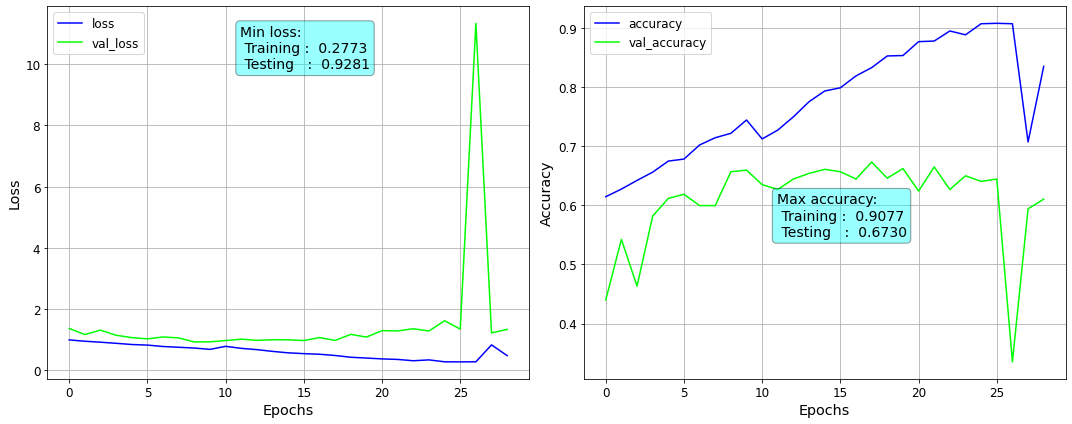

In [27]:
fn_plot_hist(res_df)

# Reload best Weights for evaluation


In [28]:
del model

In [29]:
tf.train.latest_checkpoint(checkpoint_dir)

In [ ]:
model1 = build_model(input_shape, num_classes)

model1.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

model1.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Evaluate the model

In [32]:
#yhat = model.predict(X_test, batch_size=n_batch)
yhat = model.predict(test_ds)

In [ ]:
y_test = tf.concat([y for x, y in test_ds], axis=0)

In [ ]:
y_pred = yhat.argmax(axis = 1)

print('Accuracy score on Test Data : {:.3f}%'.format( accuracy_score(y_test, y_pred)*100))

In [ ]:
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                       display_labels=class_names)

fig, ax = plt.subplots(figsize = (9,9))

disp.plot(ax = ax, cmap=plt.cm.Blues, colorbar=False);

ax.set_xticklabels(class_names,rotation=45, ha='right');

In [ ]:
for images, labels in test_ds.take( 5 ):
    
    # Predict again to keep y_pred in synch with the images
    yhat = model1.predict(images, verbos = 0)
    
    y_pred = yhat.argmax(axis = 1)
    
    for i in range ( BATCH_SIZE ):
        
        plt.subplot(int( BATCH_SIZE / 8 ), 8, i+1 )
        
        plt.grid(False)
        
        plt.imshow ( images[i].numpy().astype( "uint8" ) )
        
        plt.title('{} \n {}'.format( class_names[labels.numpy()[i]], class_names[y_pred[i]]))
        
        plt.axis("off")
        
    plt.tight_layout()
    
    plt.show()

In [ ]:
test_loss, test_acc = model1.evaluate(test_ds, verbose=1)

# Save complete model for future use

In [ ]:
model_path = checkpoint_prefix+'.h5'
model1.save(model_path, save_format='h5')

# Verify if everything was saved ok

In [33]:
new_model = tf.keras.models.load_model(model_path)

In [ ]:
new_model.summary()

In [ ]:
yhat = new_model.predict(test_ds)

y_pred = yhat.argmax(axis = 1)

print('Accuracy score on Test Data : {:.3f}%'.format( accuracy_score(y_test, y_pred)*100))